In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import os
import re
from collections import defaultdict
import matplotlib.cm as cm
from glob import glob
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [33]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/bridge"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [34]:
import os
import re

data_dir = "/Users/asapp/Documents/VAST/sim_results/phasediag/results_04"

files = sorted(glob(os.path.join(data_dir, "freq_timeseries_mu_*.pkl")))

# Regex to extract parameters
pattern = re.compile(r"mu_([\d\.]+)_map_([\d\.]+)_trial_None\.pkl")

records = []
for f in files:
    m = pattern.search(os.path.basename(f))
    if not m:
        continue
    mu, map_val = map(float, m.groups())

    with open(f, "rb") as fh:
        data = pickle.load(fh)
    freq_timeseries = np.array(data) # (2,2,t)

    # average last 100 timepoints
    final = freq_timeseries[:, :, -100:].mean(axis=-1).flatten()

    # get ordering of values (descending)
    order = tuple(np.argsort(-final))  # e.g. (0, 3, 1, 2)
    records.append((mu, map_val, order))

{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(7): 5, np.int64(8): 6, np.int64(10): 7, np.int64(11): 8, np.int64(12): 9, np.int64(14): 10}


/var/folders/8p/7dvyf8jj5778n86kw_n3hx2w0000gn/T/ipykernel_97771/593058413.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap("tab10", len(visible_indices))
/var/folders/8p/7dvyf8jj5778n86kw_n3hx2w0000gn/T/ipykernel_97771/593058413.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


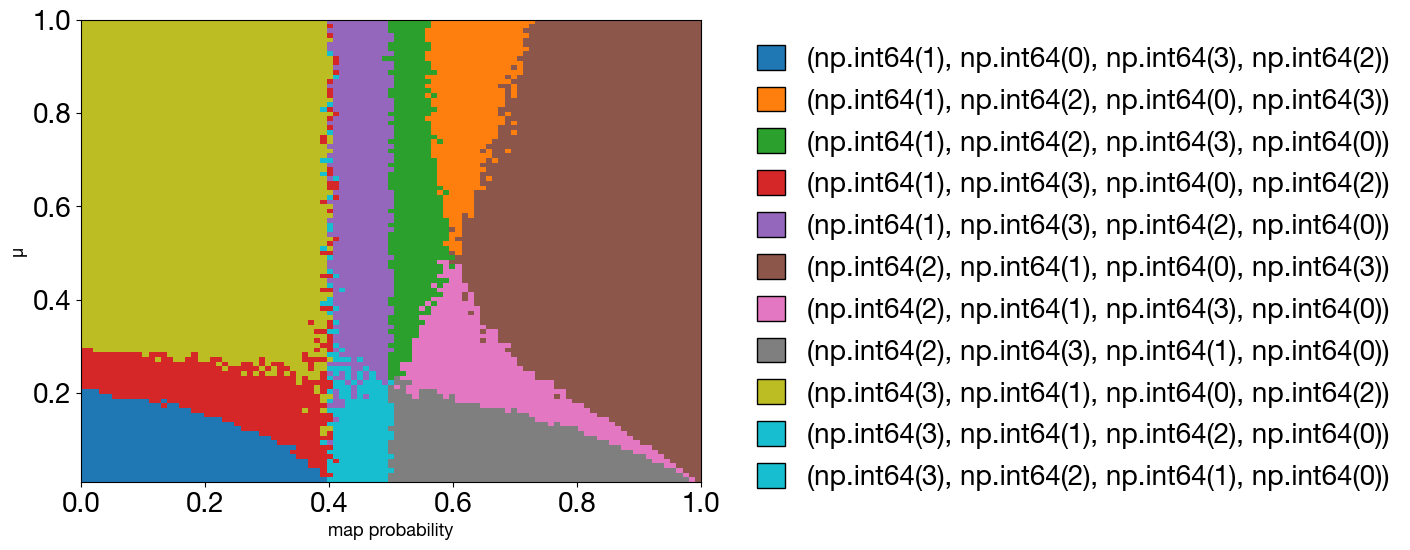

In [47]:
# --- Build sorted coordinate lists ---
mu_vals  = sorted(set(mu for mu, _, _ in records))
map_vals = sorted(set(map_val for _, map_val, _ in records))

# --- Map each (mu,map) to category index ---
unique_orders = sorted(set(order for _, _, order in records))
order_to_idx = {order:i for i,order in enumerate(unique_orders)}

grid = np.full((len(mu_vals), len(map_vals)), np.nan)
for mu, map_val, order in records:
    i = mu_vals.index(mu)       # μ → row (y-axis)
    j = map_vals.index(map_val) # map → column (x-axis)
    grid[i,j] = order_to_idx[order]

# --- Remove the bottom row (smallest μ) ---
grid = grid[1:, :]       # drop first row
mu_vals = mu_vals[1:]    # keep matching coordinate list

# --- Identify categories still present ---
visible_indices = np.unique(grid[~np.isnan(grid)]).astype(int)
visible_orders = [unique_orders[i] for i in visible_indices]
# visible_orders = [tuple(int(x) for x in t) for t in visible_orders]

# --- Create a reduced colormap with one unique color per visible ordering ---
base_cmap = plt.cm.get_cmap("tab10", len(visible_indices))
restricted_cmap = mcolors.ListedColormap([base_cmap(i) for i in range(len(visible_indices))])

# --- Remap grid to compressed category indices ---
index_map = {old_i: new_i for new_i, old_i in enumerate(visible_indices)}
print(index_map)
compressed_grid = np.full_like(grid, np.nan)
for old_i, new_i in index_map.items():
    compressed_grid[grid == old_i] = new_i

# --- Plot ---
plt.figure(figsize=(8,6))
im = plt.imshow(
    compressed_grid,
    origin="lower",
    extent=[min(map_vals), max(map_vals), min(mu_vals), max(mu_vals)],
    cmap=restricted_cmap,
    aspect="auto",
    interpolation="none"
)

plt.xlabel("map probability", fontsize=13)
plt.ylabel("μ", fontsize=13)

# --- Legend: show ordering tuples for each visible color ---
legend_elems = [
    Patch(
        facecolor=restricted_cmap(new_i),
        edgecolor='k',
        label=str(unique_orders[old_i])  # show ordering tuple
    )
    for new_i, old_i in enumerate(visible_indices)
]

plt.legend(
    handles=legend_elems,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
    handlelength=1.0,
    handleheight=1.0
)

plt.tight_layout()
plt.show()